In [257]:
import warnings
warnings.filterwarnings("ignore")

In [258]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

## Analyse Dataset

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


#### Consider movies rated by more than 200 users

In [259]:
rating_df = pd.read_csv('Ratings.csv')
book_df = pd.read_csv('Books.csv')

In [260]:
users_df = pd.read_csv('Users.csv')
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


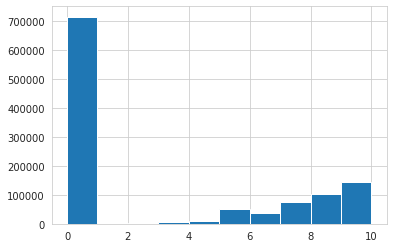

In [261]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df['Book-Rating'].hist()

In [262]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] > 100
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]

In [263]:
y = nm_rating_df.groupby('Book-Title').count()['Book-Rating']>=100
books = y[y].index

In [264]:
final_ratings = nm_rating_df[nm_rating_df['Book-Title'].isin(books)]


In [265]:
avg_rating_df = final_ratings.groupby('Book-Title').mean()['Book-Rating'].reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating_df.sort_values('avg_rating', ascending=[False]).head(10)
total_rating_df = final_ratings.groupby('Book-Title').count()['Book-Rating'].reset_index()
total_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
total_rating_df.sort_values('num_ratings', ascending=[False]).head(10)
popular_books_list = total_rating_df.merge(avg_rating_df,on='Book-Title')
popular_books_list.sort_values(['avg_rating','num_ratings'], ascending=[False,False]).head(10)

,Book-Title,num_ratings,avg_rating
96,Harry Potter and the Sorcerer's Stone (Book 1),124,5.451613
95,Harry Potter and the Prisoner of Azkaban (Book 3),197,5.025381
93,Harry Potter and the Goblet of Fire (Book 4),176,5.000000
94,Harry Potter and the Order of the Phoenix (Boo...,158,4.772152
92,Harry Potter and the Chamber of Secrets (Book 2),253,4.494071
66,Ender's Game (Ender Wiggins Saga (Paperback)),101,4.099010
13,A Wrinkle in Time,100,3.920000
295,To Kill a Mockingbird,244,3.918033
234,The Hobbit : The Enchanting Prelude to The Lor...,110,3.900000
285,"The Two Towers (The Lord of the Rings, Part 2)",119,3.890756


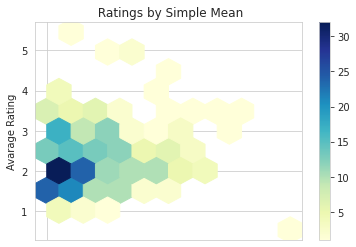

In [266]:
grid   = pd.DataFrame({
                    'Avarage Rating': popular_books_list['avg_rating'],
                    'Number of Reviewers': popular_books_list['num_ratings']
                 })
grid.plot(x='Number of Reviewers', y='Avarage Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=10, mincnt=1,
                  title=" Ratings by Simple Mean")
plt.show()


### Prepare train test set

In [267]:
final_ratings=final_ratings.sort_values(by=['User-ID','Book-Rating'], ascending=[False,False]) 
final_ratings.shape

(48237, 10)

In [268]:
test_df=final_ratings.groupby('User-ID').head(10)
test_df.shape

(15124, 10)

In [269]:
final_ratings=final_ratings[~final_ratings.isin(test_df).all(1)]
final_ratings.shape

(33113, 10)

### Consider User rated more than 50 tumes

### Install packages

In [270]:
!pip install networkx
!pip install stellargraph
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Final data set

In [271]:
graph_df=final_ratings
graph_df=graph_df[['User-ID','Book-Title','Book-Rating']]
graph_df.columns = ['source', 'target', 'weights']
graph_df.head(1)

,source,target,weights
5034,278418,Disclosure,0


In [272]:
test_df.head(1)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
6747,278418,0515130389,8,Carolina Moon,Nora Roberts,2001,Jove Books,http://images.amazon.com/images/P/0515130389.0...,http://images.amazon.com/images/P/0515130389.0...,http://images.amazon.com/images/P/0515130389.0...


## Graph Embeddings


###  Step1: Create the rating matrix with rows as movies and columns as users.

In [273]:
import networkx as nx

### Create a weighted graph of user Item using python library networkx, stellargraph
- https://snap.stanford.edu/node2vec/
- https://github.com/aditya-grover/node2vec

- https://towardsdatascience.com/complete-guide-to-understanding-node2vec-algorithm-4e9a35e5d147
- https://towardsdatascience.com/node2vec-explained-db86a319e9ab
- https://github.com/stellargraph/stellargraph

In [274]:
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

In [275]:
G = StellarGraph(edges=graph_df)

In [276]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=80,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 15400


#### compute random walk

In [277]:

from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

#### Save model and use for recommendation

In [278]:
model.save("word2vec.model")

In [279]:
model = Word2Vec.load("word2vec.model")

In [280]:
node_embeddings= model.wv

In [281]:
import networkx as nx

In [282]:
user_item_edge_list = graph_df[['source', 'target', 'weights']]
user_item_edge_list.head()

,source,target,weights
5034,278418,Disclosure,0
5839,278418,Ellen Foster,0
5855,278418,Watership Down,0
5862,278418,The Thorn Birds,0
5916,278418,American Gods,0


### Make predictions

In [283]:

book_df[book_df['Book-Title']=="Harry Potter and the Chamber of Secrets (Book 2)"].head(1)
#book_df[book_df['Book-Title']=='Animal Farm']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...


In [284]:
book_df[book_df['Book-Title']=="Harry Potter and the Sorcerer's Stone (Book 1)"].head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...


In [285]:
book1 = "Harry Potter and the Sorcerer's Stone (Book 1)"
book2 = "Harry Potter and the Chamber of Secrets (Book 2)"

##### Check cosine similarity

In [286]:

from scipy.spatial.distance import cosine
1.0 - cosine(node_embeddings[book1], node_embeddings[book2])

0.5908518433570862

Since we worked with integer ids for nodes, let's create reverse mapping dictionaries that map integer user/movie to their actual ids. 

In [287]:
from sklearn.metrics.pairwise import cosine_similarity


In [288]:
df=user_item_edge_list['target'].unique()

In [289]:
df=list(df)
df.sort()


In [290]:
book1 = "Harry Potter and the Sorcerer's Stone (Book 1)"


In [291]:
result= {}
for i in df:
  if(i!="Harry Potter and the Sorcerer's Stone (Book 1)"):
    book2 = i
    cos=0
    try:
      cos=1.0 - cosine(node_embeddings[book1], node_embeddings[book2])
    except:
      pass
    result[i]=cos

In [292]:
from collections import Counter
result=dict(Counter(result).most_common(10))

In [293]:

result= list(result.keys())

In [294]:

book_df[book_df['Book-Title'].isin(result)].groupby('Book-Title').head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
800,0064407667,The Bad Beginning (A Series of Unfortunate Eve...,Lemony Snicket,1999,HarperCollins,http://images.amazon.com/images/P/0064407667.0...,http://images.amazon.com/images/P/0064407667.0...,http://images.amazon.com/images/P/0064407667.0...
1057,055321313X,Anne of Green Gables (Anne of Green Gables Nov...,L.M. MONTGOMERY,1982,Bantam Classics,http://images.amazon.com/images/P/055321313X.0...,http://images.amazon.com/images/P/055321313X.0...,http://images.amazon.com/images/P/055321313X.0...
2885,034538475X,The Tale of the Body Thief (Vampire Chronicles...,Anne Rice,1993,Ballantine Books,http://images.amazon.com/images/P/034538475X.0...,http://images.amazon.com/images/P/034538475X.0...,http://images.amazon.com/images/P/034538475X.0...
2910,0380718340,Cruel &amp; Unusual (Kay Scarpetta Mysteries (...,Patricia D. Cornwell,1994,Avon,http://images.amazon.com/images/P/0380718340.0...,http://images.amazon.com/images/P/0380718340.0...,http://images.amazon.com/images/P/0380718340.0...
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...
3739,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
4114,0060809833,Brave New World,Aldous Huxley,1989,Harpercollins,http://images.amazon.com/images/P/0060809833.0...,http://images.amazon.com/images/P/0060809833.0...,http://images.amazon.com/images/P/0060809833.0...
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...


## Evaluate our result
- We will generate top 10 recommendations for 100 user and calculate the hit rate in test data set.

In [295]:
userlist=list(graph_df.source.unique())[:100]

In [296]:
data=graph_df[graph_df['source'].isin(userlist)]

In [297]:
test_df=test_df[test_df['User-ID'].isin(userlist)]

In [298]:
result=data.sort_values(by=['source','weights'],ascending=[True,False])
result=result.groupby('source').head(10)

In [299]:
result.head(1)

,source,target,weights
1063700,254241,The Hitchhiker's Guide to the Galaxy,0


In [300]:
from collections import Counter
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['source']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
    
    movieid=row['target'] 
    movie1 = movieid
    res_dict= {}
    for i in df:
      if(i!=movieid):
        movie2 = i
        cos=1.0 - cosine(node_embeddings[movie1], node_embeddings[movie2])
        res_dict[i]=cos
    
    res=dict(Counter(res_dict).most_common(10))
    indexes= list(res.keys())    
    
  
    for ids in indexes:
        if(ids==movieid):
            continue
        if(~((result['target'] == ids) & (result['source'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
        
        

In [301]:
# Iterating over values
recommendations=[]
for userid, books in recommend_dict.items():
    total=0
    mlist=[]
    for i in books:
        total+=1
        mlist.append(i)
        if(total>10):
            break
    recommendations.append([userid,mlist])

In [302]:
recommendations=pd.DataFrame(recommendations,columns=['user_id','books'])

### Calculate Hit Ratio
- See how often we recommended a movie the user actually rated

In [303]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    total+=1
    for rs in results:
        
        if(((test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i)).any()):
                hit+=1
                break
        
hit_ratio=hit/total   
print(hit_ratio)

0.53


### MAP@K

In [304]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
   
    for rs in results:
        total+=1
        if(((test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i)).any()):
                hit+=1
                
        
mapk=hit/total   
print(mapk)

0.09881061299176579


### Add Author informations

In [305]:
book_author_edgelist = book_df[['Book-Title', 'Book-Author']]
book_author_edgelist.head(1)

,Book-Title,Book-Author
0,Classical Mythology,Mark P. O. Morford


In [306]:
book_author_edgelist.drop_duplicates()

,Book-Title,Book-Author
0,Classical Mythology,Mark P. O. Morford
1,Clara Callan,Richard Bruce Wright
2,Decision in Normandy,Carlo D'Este
3,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,The Mummies of Urumchi,E. J. W. Barber
...,...,...
271354,Flashpoints: Promise and Peril in a New World,Robin Wright
271356,From One to One Hundred,Teri Sloat
271357,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271358,Republic (World's Classics),Plato


In [307]:
book_author_edgelist=book_author_edgelist[book_author_edgelist['Book-Title'].isin(list(graph_df['target']))]

In [308]:
book_author_graph = nx.Graph()
for x in book_author_edgelist.values:
    book = x[0]
    author = x[1]
   
    book_author_graph.add_node(book)
    book_author_graph.add_node(author)
    book_author_graph.add_edge(book, author, weight=1.0)
           

In [309]:
book_author_graph = nx.Graph()
for x in book_author_edgelist.values:
    book = x[0]
    author = x[1]
   
    book_author_graph.add_node(book)
    book_author_graph.add_node(author)
    book_author_graph.add_edge(book, author, weight=1.0)
           

In [310]:
user_book_graph = nx.Graph()
for x in user_item_edge_list.values:

    usr = x[0]
    book = x[1]
    user_book_graph.add_node(usr)
    user_book_graph.add_node(book)
    user_book_graph.add_edge(usr, book, weight=float(x[2]))

In [311]:
user_book_author_graph =  nx.Graph()
user_book_author_graph.add_weighted_edges_from([(x,y,book_author_graph[x][y]['weight']) for x,y in book_author_graph.edges()])
user_book_author_graph.add_weighted_edges_from([(x,y,user_book_graph[x][y]['weight']) for x,y in user_book_graph.edges()])

In [312]:
G = StellarGraph(user_book_author_graph)

In [313]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=80,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 18460


In [314]:

from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [315]:
model.save("word2vec1.model")

In [316]:
node_embeddings= model.wv

In [317]:
result= {}
for i in df:
  if(i!="Harry Potter and the Sorcerer's Stone (Book 1)"):
    book2 = i
    cos=0
    try:
      cos=1.0 - cosine(node_embeddings[book1], node_embeddings[book2])
    except:
      pass
    result[i]=cos

In [318]:
from collections import Counter
result=dict(Counter(result).most_common(10))
result= list(result.keys())
book_df[book_df['Book-Title'].isin(result)].groupby('Book-Title').head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
114,0446612545,The Beach House,James Patterson,2003,Warner Books,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...
800,0064407667,The Bad Beginning (A Series of Unfortunate Eve...,Lemony Snicket,1999,HarperCollins,http://images.amazon.com/images/P/0064407667.0...,http://images.amazon.com/images/P/0064407667.0...,http://images.amazon.com/images/P/0064407667.0...
2802,0060392452,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002,Regan Books,http://images.amazon.com/images/P/0060392452.0...,http://images.amazon.com/images/P/0060392452.0...,http://images.amazon.com/images/P/0060392452.0...
3354,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...,http://images.amazon.com/images/P/0345339681.0...
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...,http://images.amazon.com/images/P/0439064872.0...
3739,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
4206,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...


In [319]:
userlist=list(graph_df.source.unique())[:100]
data=graph_df[graph_df['source'].isin(userlist)]
test_df=test_df[test_df['User-ID'].isin(userlist)]
result=data.sort_values(by=['source','weights'],ascending=[True,False])
result=result.groupby('source').head(10)




In [320]:

from collections import Counter
top_n = 10
k = 50
top_n = 10

recommend_dict = { }
for index, row in result.iterrows():
    user=row['source']
    if user not in recommend_dict.keys():
        recommend_dict[user]={}
    
    movieid=row['target'] 
    movie1 = movieid
    res_dict= {}
    for i in df:
      if(i!=movieid):
        movie2 = i
        cos=1.0 - cosine(node_embeddings[movie1], node_embeddings[movie2])
        res_dict[i]=cos
    
    res=dict(Counter(res_dict).most_common(10))
    indexes= list(res.keys())    
    
  
    for ids in indexes:
        if(ids==movieid):
            continue
        if(~((result['target'] == ids) & (result['source'] ==user)).any()):
            if ids not in recommend_dict[user].keys():
                recommend_dict[user][ids] =1
            else:
                recommend_dict[user][ids]+=1
                    
        
    
  

In [321]:
# Iterating over values
recommendations=[]
for userid, books in recommend_dict.items():
    total=0
    mlist=[]
    for i in books:
        total+=1
        mlist.append(i)
        if(total>10):
            break
    recommendations.append([userid,mlist])

In [322]:

recommendations=pd.DataFrame(recommendations,columns=['user_id','books'])

### Calculate hit rate

In [330]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i)].any().any()):
                hit+=1
                break
        
hit_ratio_with_author=hit/total   
print(hit_ratio_with_author)

0.58


### Hit rate  on number of time user liked recommended items

In [331]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
    total+=1
    for rs in results:
        
        if(test_df[(test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i) &( test_df['Book-Rating'] >8)].any().any()):
                hit+=1
                break
        
hit_ratio_with_author_popular=hit/total   
print(hit_ratio_with_author_popular)

0.26


### MAP@K

In [324]:
total=0
hit=0
for i in userlist:
    results=recommendations[recommendations.user_id==i]
    results=list(results.books)[0]
   
    for rs in results:
        total+=1
        if(((test_df['Book-Title'] == rs) & (test_df['User-ID'] ==i)).any()):
                hit+=1
                
        
map_k_with_author=hit/total   
print(map_k_with_author)

0.09972552607502287
